# Analysis and Visualization of Complex Agro-Environmental Data
---

In [36]:
# import the packages we are going to be using
import numpy as np # for getting our distribution
import pandas as pd # to handle data frames
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting
from scipy import stats # to compute statistics
from sklearn.ensemble import IsolationForest

In [17]:
# Read in data
df = pd.read_csv('EFIplus_medit.zip',compression='zip', sep=";")
df.head()

Site_code   Latitude  Longitude Country Catchment_name  Galiza  Subsample  \
0  ES_01_0002  38.102003  -4.096070   Spain   Guadalquivir       0          1   
1  ES_02_0001  40.530188  -1.887796   Spain           Tejo       0          1   
2  ES_02_0002  40.595432  -1.928079   Spain           Tejo       0          1   
3  ES_02_0003  40.656184  -1.989831   Spain           Tejo       0          1   
4  ES_02_0004  40.676402  -2.036274   Spain           Tejo       0          1   

   Calib_EFI_Medit  Calib_connect  Calib_hydrol  ...  Squalius malacitanus  \
0                0              1             0  ...                     0   
1                1              1             1  ...                     0   
2                1              1             1  ...                     0   
3                1              1             1  ...                     0   
4                1              1             1  ...                     0   

   Squalius pyrenaicus  Squalius torgalensis  Thymallus thymallus  \
0                    0                     0                    0   
1                    0                     0                    0   
2                    0                     0                    0   
3                    0                     0                    0   
4                    0                     0                    0   

   Tinca tinca Zingel asper Squalius sp  Barbatula sp Phoxinus sp  \
0            0            0           0             0           0   
1            0            0           0             0           0   
2            0            0           0             0           0   
3            0            0           0             0           0   
4            0            0           0             0           0   

   Iberochondrostoma_sp  
0                     0  
1                     0  
2                     0  
3                     0  
4                     0  

[5 rows x 164 columns]

### 1. Check visually if any of the continuous environmental variables in the EFIplus_medit dataset (Altitude, Actual_river_slope, Elevation_mean_catch, prec_ann_catch, temp_ann, temp_jan, temp_jul) would require a data transformation in order to apply parametric tests.

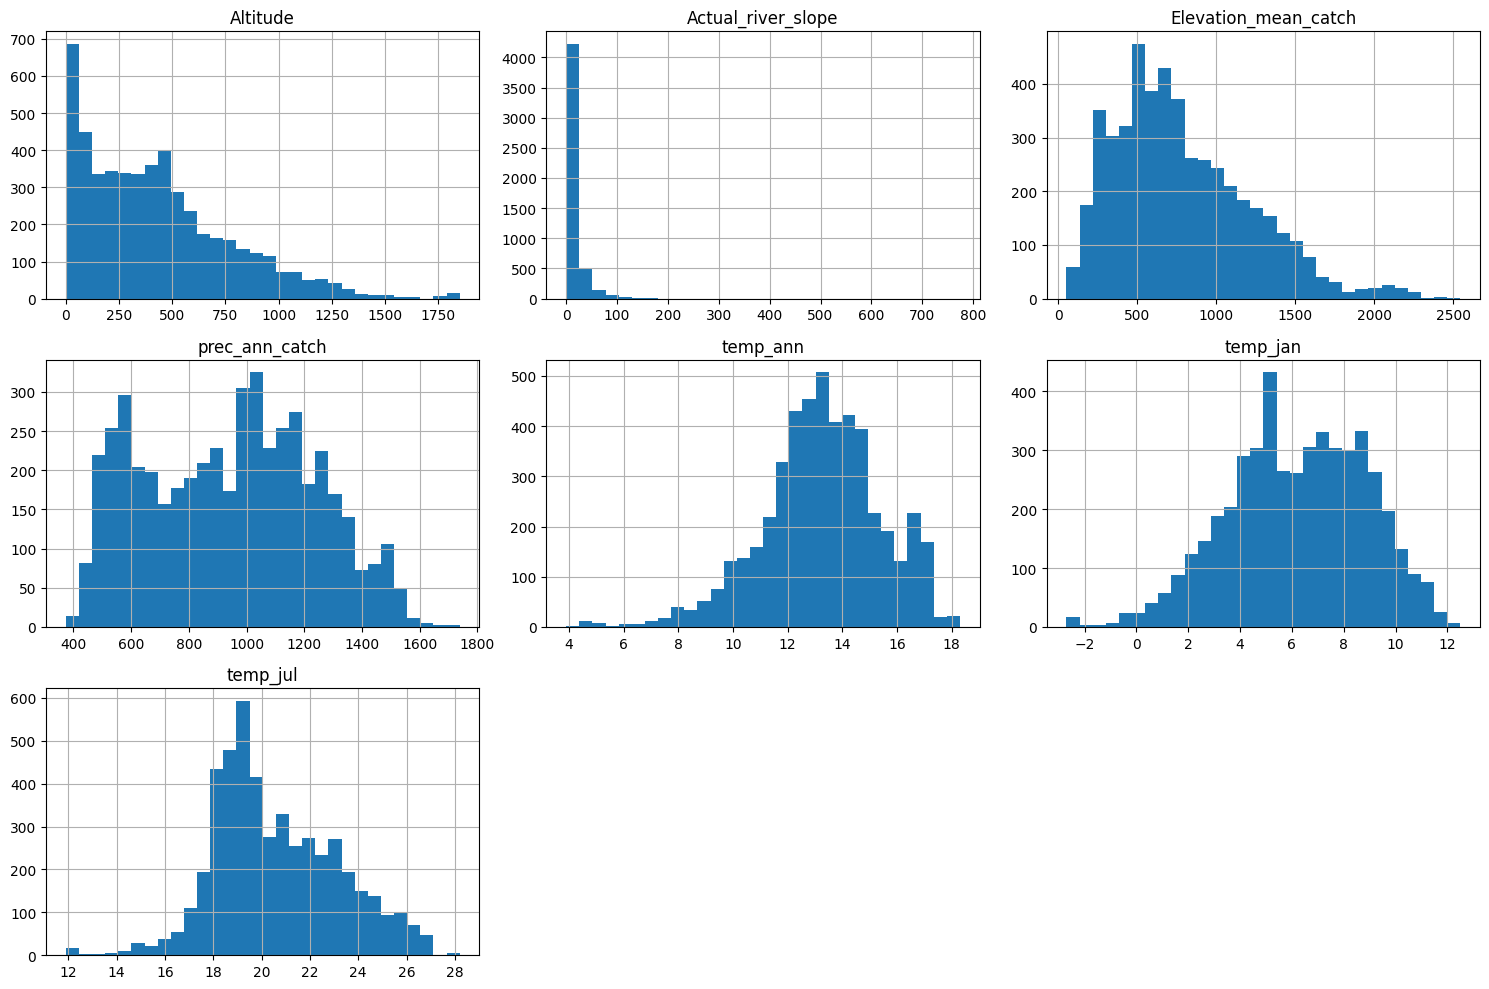

In [14]:
# List of continuous environmental variables
variables = [
    'Altitude', 'Actual_river_slope', 'Elevation_mean_catch',
    'prec_ann_catch', 'temp_ann', 'temp_jan', 'temp_jul'
]

# Set up the figure and axes
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
axes = axes.flatten()  # Flatten to easily index in a loop

# Plot each variable's histogram
for i, var in enumerate(variables):
    df[var].hist(bins=30, ax=axes[i])
    axes[i].set_title(var)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

# Remove any unused subplot (since 3x3 = 9 and we only have 7 variables)
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

'Actual_river_slope', 'Altitude', 'Elevation_mean_catch', 'prec_ann_catch' all require some transformation in order to apply parameteric tests.

### 2. Apply the appropriate data transformation and check the new distributions.

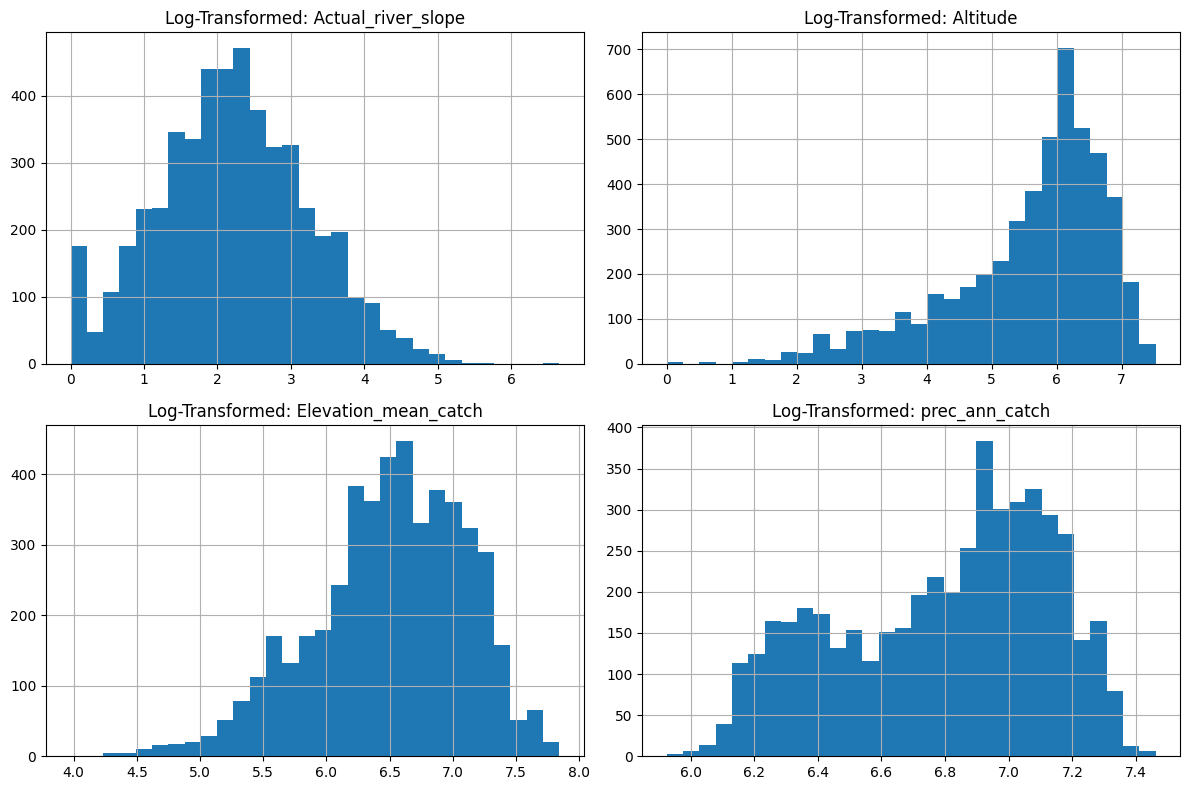

In [6]:
# List of right-skewed variables to transform
transformed_vars = ['Actual_river_slope', 'Altitude', 'Elevation_mean_catch', 'prec_ann_catch']

# Apply log(x + 1) transformation
for var in transformed_vars:
    df[f'log_{var}'] = np.log1p(df[var])

# Plot all transformed variables in one pane
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes = axes.flatten()

for i, var in enumerate(transformed_vars):
    log_var = f'log_{var}'
    df[log_var].hist(bins=30, ax=axes[i])
    axes[i].set_title(f'Log-Transformed: {var}')
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')

plt.tight_layout()
plt.show()

After log transformation, we see that altitude is now skewed left, meaning that the log transformation might not be the appropriate transformation in this case. In order to correct this, a root square transformation was applied instead of log, which yielded better results. 

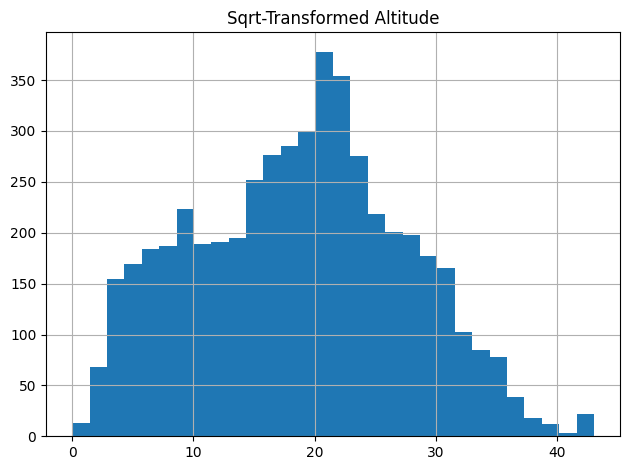

In [11]:
# Square root-transformed altitude
df['sqrt_Altitude'] = np.sqrt(df['Altitude'])
df['sqrt_Altitude'].hist(bins=30)

plt.title('Sqrt-Transformed Altitude')

plt.tight_layout()
plt.show()

### 3. Create a column with the total number of species present (the species richness) in each sampling site (NOTE: the first species in the dataset is ‘Abramis brama’ and all the columns to the right correspond to species presence/absence).

In [21]:
# ID the first species column
species_start = df.columns.get_loc('Abramis brama')

In [22]:
# Get everything from species start to the end of the df
species_df = df.iloc[:, species_start:]

In [25]:
# Convert absence and presence to 0/1
species_binary = (species_df > 0).astype(int)

In [31]:
# Sum across each row to get species richness
df['species_richness'] = species_binary.sum(axis=1)

### 4. Check the existence of bivariate outliers in the relationship between Mean Annual Temperature (‘temp_ann’) and species richness using an appropriate plot. Run a bivariate isolation forest to detect outliers and plot the result.

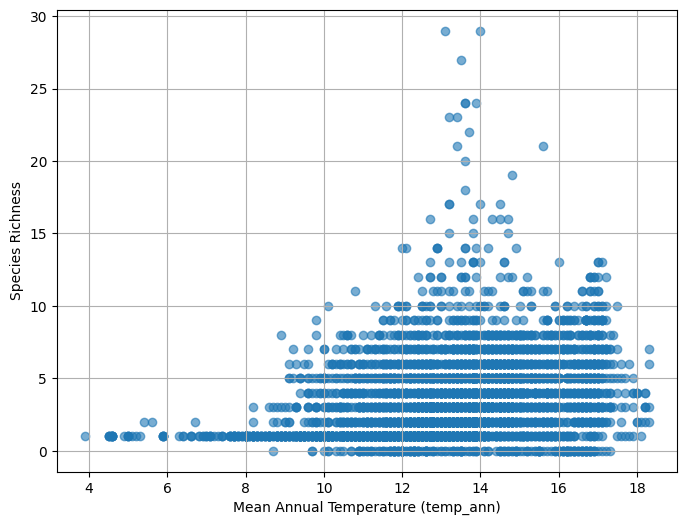

In [35]:
# Plot temp_ann vs. species_richness
plt.figure(figsize=(8, 6))
plt.scatter(df['temp_ann'], df['species_richness'], alpha=0.6)
plt.xlabel('Mean Annual Temperature (temp_ann)')
plt.ylabel('Species Richness')
plt.grid(True)
plt.show()

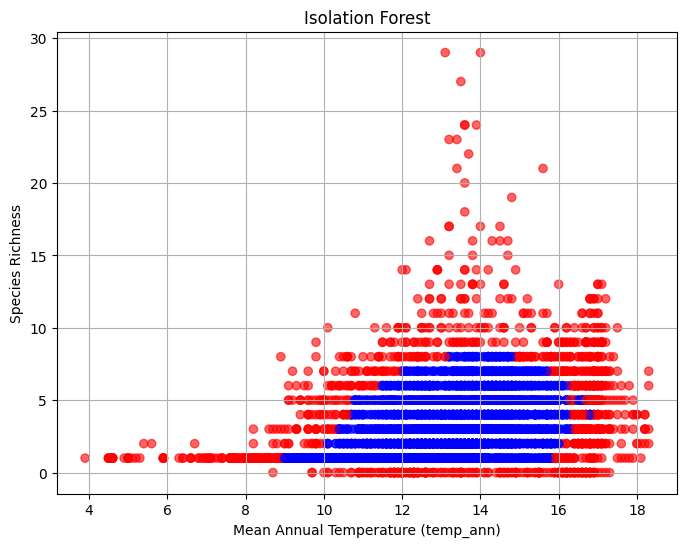

In [38]:
X = df[['temp_ann', 'species_richness']].dropna()

iso = IsolationForest(contamination='auto', random_state=42)
X['outlier'] = iso.fit_predict(X)

# Plot results
plt.figure(figsize=(8, 6))
# -1 = outlier
colors = X['outlier'].map({1: 'blue', -1: 'red'})
plt.scatter(X['temp_ann'], X['species_richness'], c=colors, alpha=0.6)
plt.xlabel('Mean Annual Temperature (temp_ann)')
plt.ylabel('Species Richness')
plt.title('Isolation Forest')
plt.grid(True)
plt.show()

In the isolation forest plot, the red dots are outliers and the blue are normal.  
The blue region indicates areas where the model expects typical combinations of temp_ann and species_richness. Most of the data points are found here. The red dots indicate points with unusual combinations, such as low species richness at higher temperatures or very high richness in areas with low temperatures.

### 5. Explore visually, using a single plot, if this relationship (temp_ann x species richness) may vary across countries.

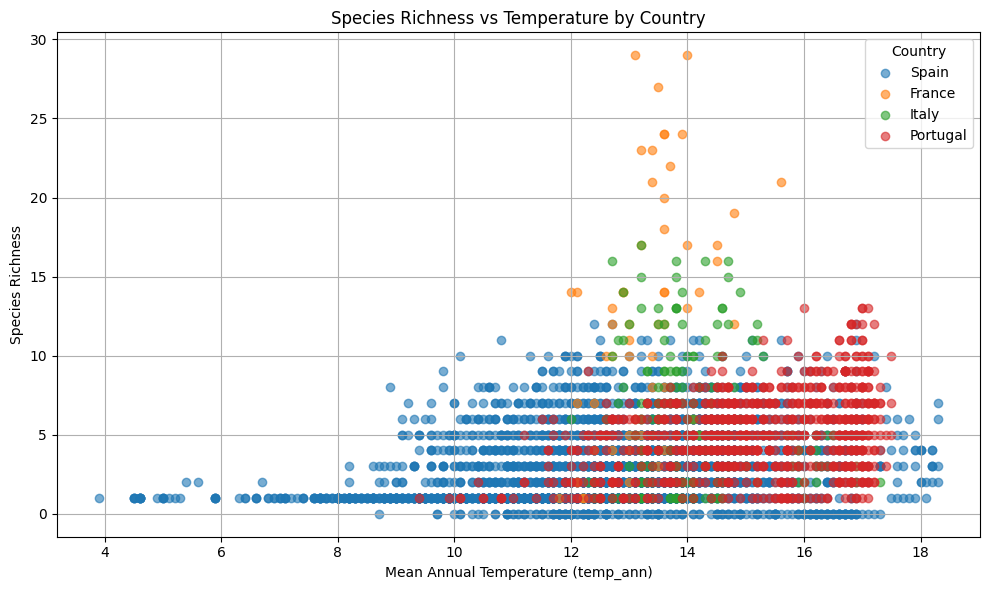

In [39]:
# Drop NA for clean plotting
plot_data = df[['temp_ann', 'species_richness', 'Country']].dropna()

# Create scatterplot with color by Country
plt.figure(figsize=(10, 6))
for country in plot_data['Country'].unique():
    subset = plot_data[plot_data['Country'] == country]
    plt.scatter(subset['temp_ann'], subset['species_richness'], label=country, alpha=0.6)

plt.xlabel('Mean Annual Temperature (temp_ann)')
plt.ylabel('Species Richness')
plt.title('Species Richness vs Temperature by Country')
plt.legend(title='Country')
plt.grid(True)
plt.tight_layout()
plt.show()

From this plot, we can see various patterns. In Spain, there is a wide range of mean annual temperatures, but species richness stays between 0 and 10. In contrast, France shows a narrower temperature range but generally higher species richness within that range. Italy has a similar pattern, with high richness concentrated within a limited temperature range. Portugal spans a smaller temperature range than Spain, but species richness shows a similarly constrained pattern, generally staying below 10.